# Imports

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Reading the GPU Specs CSV

In [108]:
df = pd.read_csv('gpu_specs_v6.csv')

# Data Quality Checks

In [109]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   manufacturer   2889 non-null   object 
 1   productName    2889 non-null   object 
 2   releaseYear    2845 non-null   float64
 3   memSize        2477 non-null   float64
 4   memBusWidth    2477 non-null   float64
 5   gpuClock       2889 non-null   int64  
 6   memClock       2477 non-null   float64
 7   unifiedShader  2065 non-null   float64
 8   tmu            2889 non-null   int64  
 9   rop            2889 non-null   int64  
 10  pixelShader    824 non-null    float64
 11  vertexShader   824 non-null    float64
 12  igp            2889 non-null   object 
 13  bus            2889 non-null   object 
 14  memType        2889 non-null   object 
 15  gpuChip        2889 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory usage: 361.2+ KB
None
       releaseYear      memSize 

# Data Exploration part

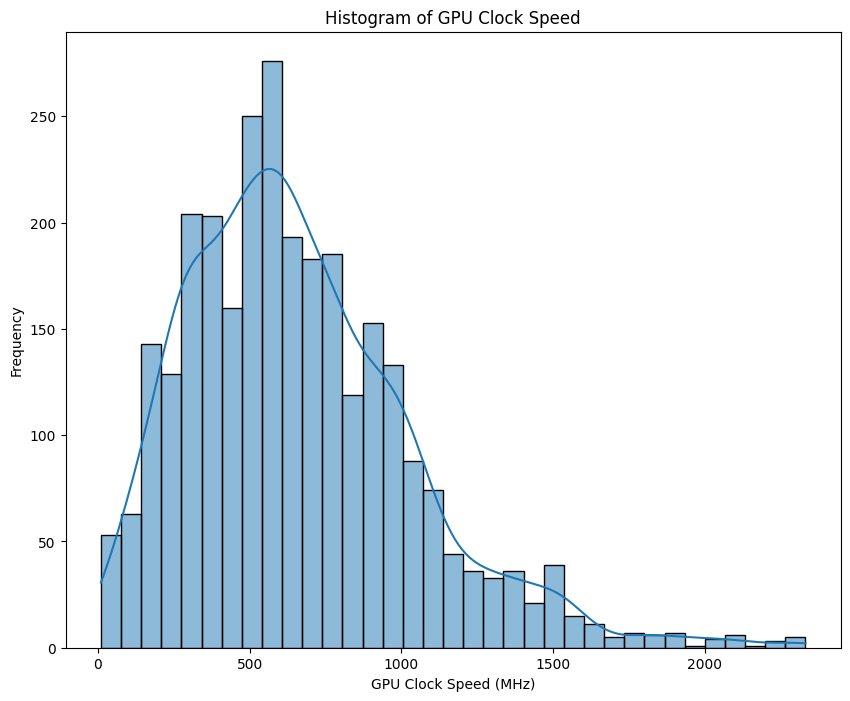

In [110]:
plt.figure(figsize=(10, 8))
sns.histplot(df['gpuClock'], kde=True)
plt.title('Histogram of GPU Clock Speed')
plt.xlabel('GPU Clock Speed (MHz)')
plt.ylabel('Frequency')
plt.show()

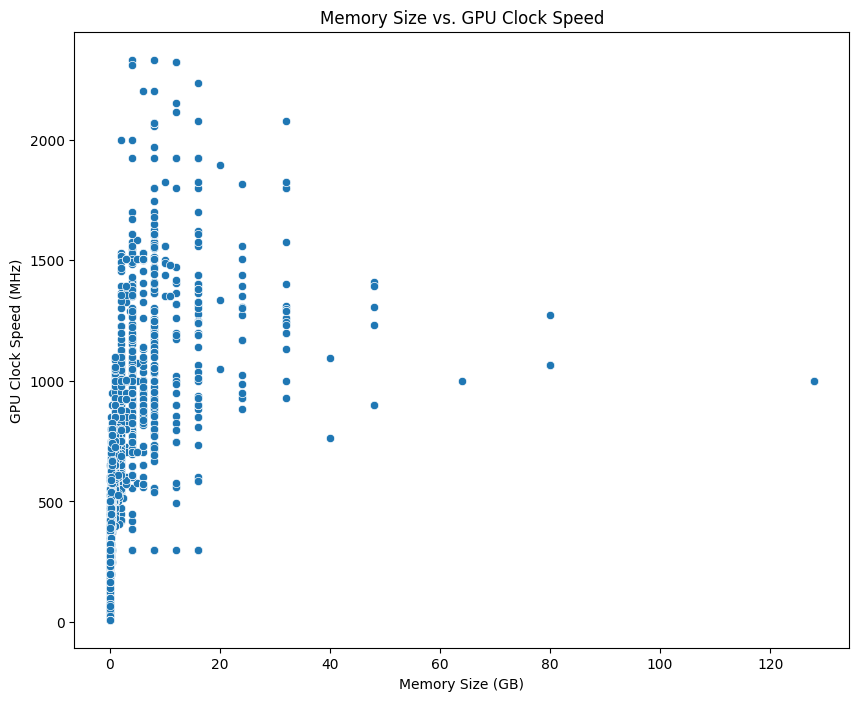

In [111]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='memSize', y='gpuClock', data=df)
plt.title('Memory Size vs. GPU Clock Speed')
plt.xlabel('Memory Size (GB)')
plt.ylabel('GPU Clock Speed (MHz)')
plt.show()

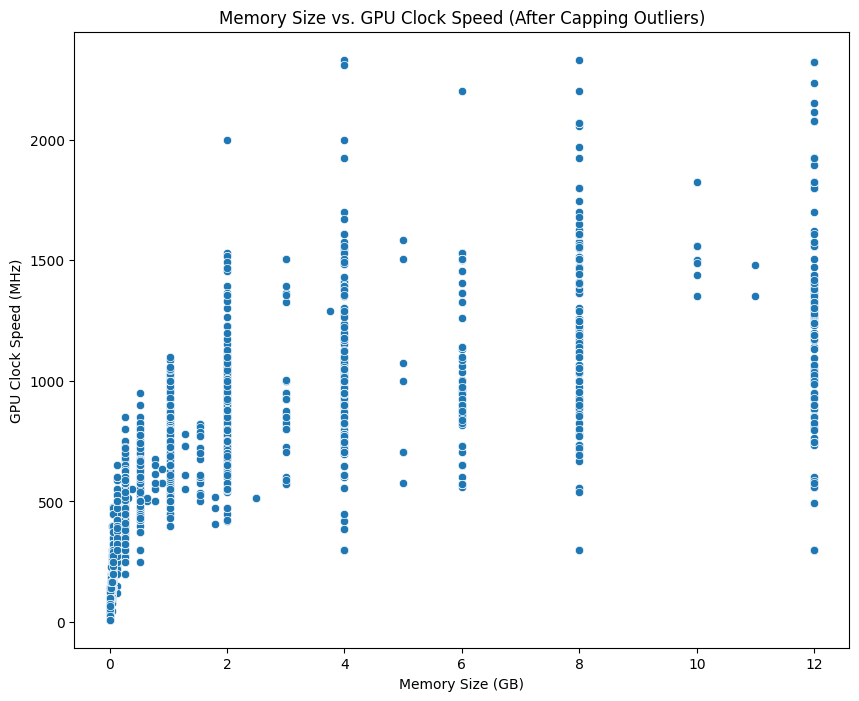

In [112]:
# Capping the outlier
max_value = df['memSize'].quantile(0.95)
df.loc[df['memSize'] > max_value, 'memSize'] = max_value

plt.figure(figsize=(10, 8))
sns.scatterplot(x='memSize', y='gpuClock', data=df)
plt.title('Memory Size vs. GPU Clock Speed (After Capping Outliers)')
plt.xlabel('Memory Size (GB)')
plt.ylabel('GPU Clock Speed (MHz)')
plt.show()

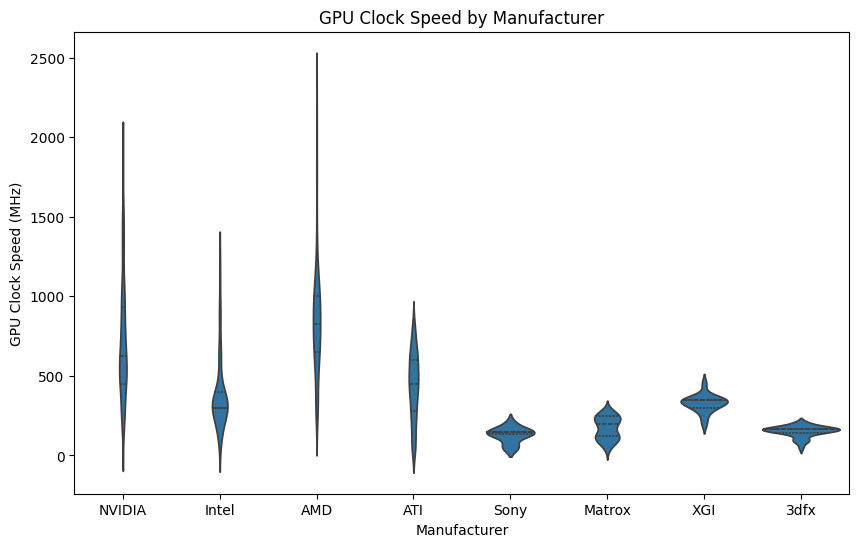

In [113]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='manufacturer', y='gpuClock', data=df, inner='quartile')
plt.title('GPU Clock Speed by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('GPU Clock Speed (MHz)')
plt.show()

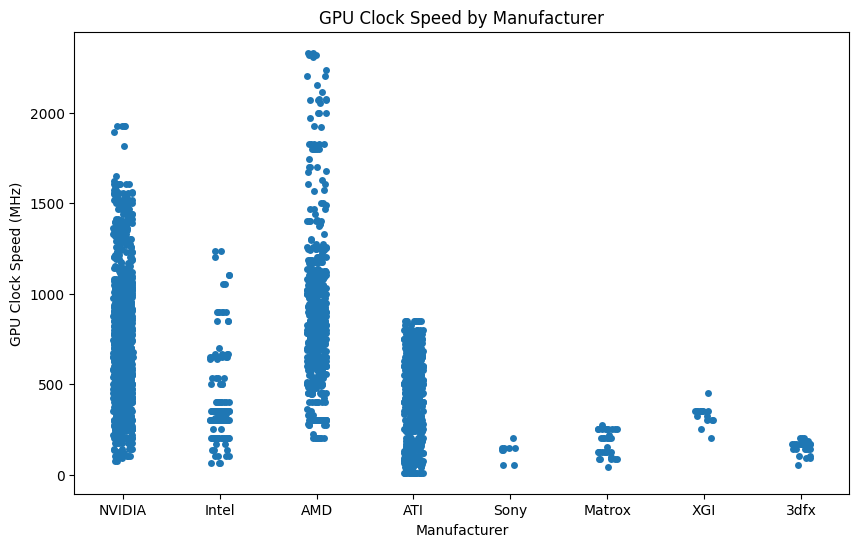

In [114]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='manufacturer', y='gpuClock', data=df, jitter=True)
plt.title('GPU Clock Speed by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('GPU Clock Speed (MHz)')
plt.show()

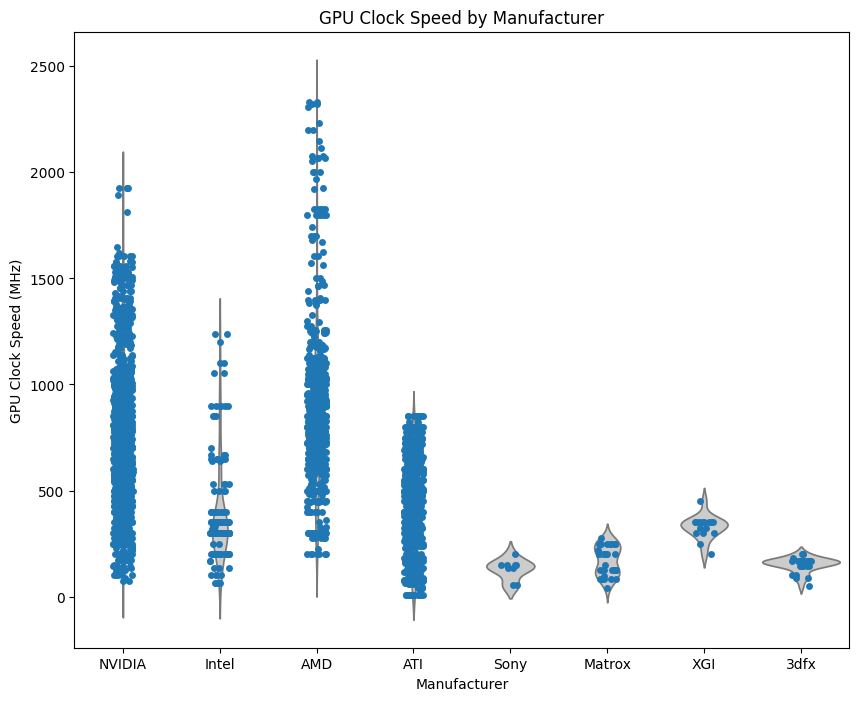

In [115]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='manufacturer', y='gpuClock', data=df, inner=None, color=".8")
sns.stripplot(x='manufacturer', y='gpuClock', data=df, jitter=True)
plt.title('GPU Clock Speed by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('GPU Clock Speed (MHz)')
plt.show()


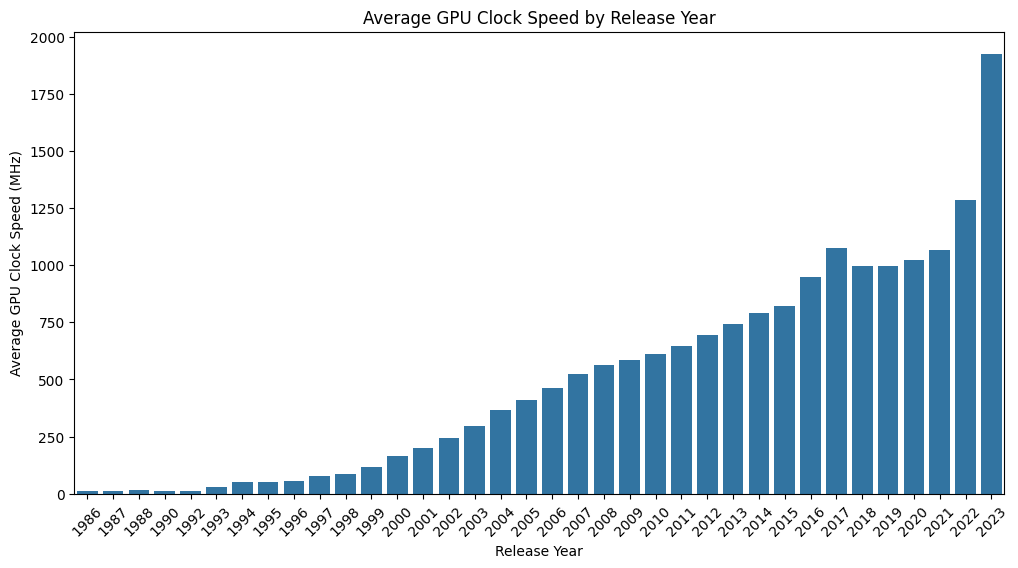

In [116]:
avg_gpu_clock_per_year = df.groupby('releaseYear')['gpuClock'].mean().reset_index()
avg_gpu_clock_per_year['releaseYear'] = avg_gpu_clock_per_year['releaseYear'].astype(int)
plt.figure(figsize=(12, 6))
sns.barplot(x='releaseYear', y='gpuClock', data=avg_gpu_clock_per_year)
plt.title('Average GPU Clock Speed by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average GPU Clock Speed (MHz)')
plt.xticks(rotation=45)
plt.show()

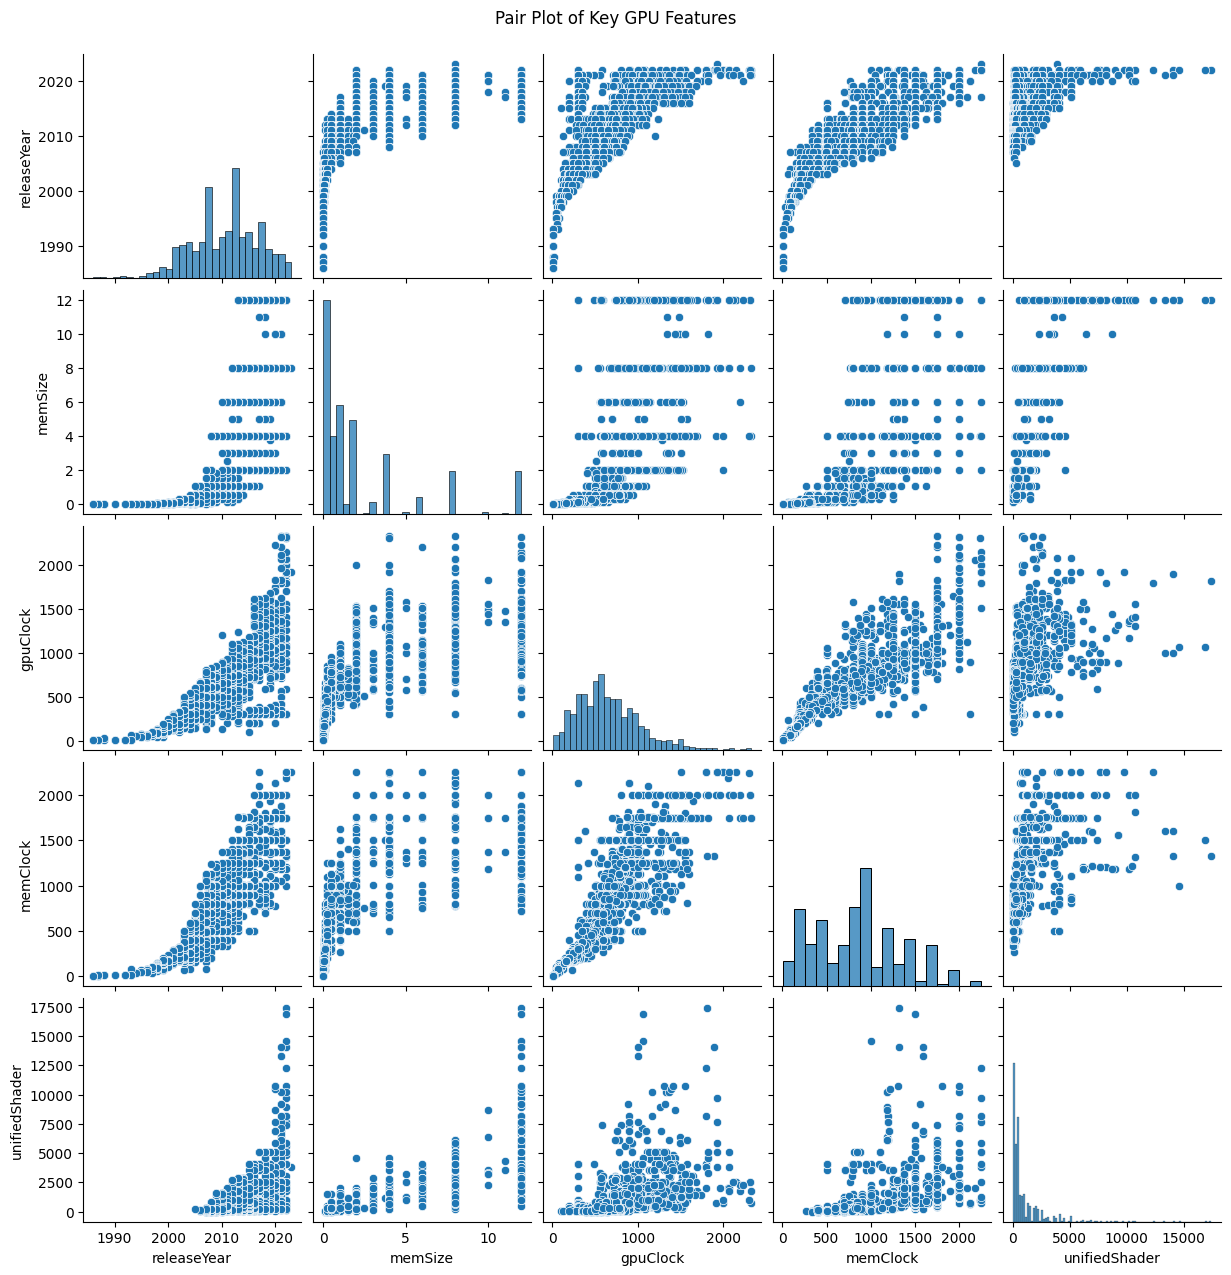

In [117]:
sns.pairplot(df[['releaseYear', 'memSize', 'gpuClock', 'memClock', 'unifiedShader']])
plt.suptitle('Pair Plot of Key GPU Features', y=1.02)
plt.show()

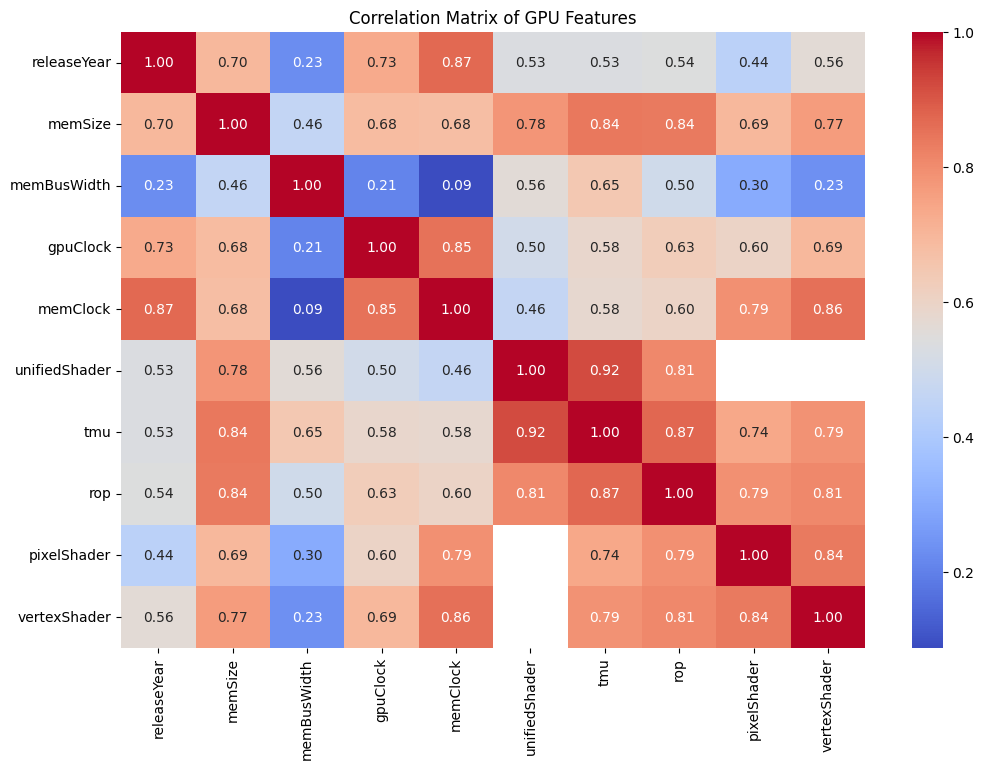

In [118]:
numerical_cols = df.select_dtypes(include=[np.number])
corr_matrix = numerical_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of GPU Features')
plt.show()

# Imputation/Feature Engineering

In [119]:
df_numeric = df[['releaseYear', 'memSize', 'memBusWidth', 'memClock']]
knn_imputer = KNNImputer(n_neighbors=3)
df_numeric_imputed = pd.DataFrame(knn_imputer.fit_transform(df_numeric), columns=df_numeric.columns)
df_numeric_imputed = df_numeric_imputed.round()


In [120]:
unified_shader_median = df['unifiedShader'].median()
df['unifiedShader'] = df['unifiedShader'].fillna(unified_shader_median)
df[['releaseYear', 'memSize', 'memBusWidth', 'memClock']] = df_numeric_imputed
df = df.drop(columns=['vertexShader', 'pixelShader'])
print(df)

     manufacturer       productName  releaseYear  memSize  memBusWidth  \
0          NVIDIA  GeForce RTX 4050       2023.0      8.0        128.0   
1           Intel         Arc A350M       2022.0      4.0         64.0   
2           Intel         Arc A370M       2022.0      4.0         64.0   
3           Intel          Arc A380       2022.0      4.0         64.0   
4           Intel         Arc A550M       2022.0      8.0        128.0   
...           ...               ...          ...      ...          ...   
2884         3dfx  Voodoo5 5000 AGP       1999.0      0.0        128.0   
2885         3dfx  Voodoo5 5000 PCI       1999.0      0.0        128.0   
2886         3dfx      Voodoo5 6000       2000.0      0.0        128.0   
2887        Intel            Xe DG1       2021.0      4.0        128.0   
2888        Intel        Xe DG1-SDV       2021.0      8.0        128.0   

      gpuClock  memClock  unifiedShader  tmu  rop igp           bus  memType  \
0         1925    2250.0       

In [121]:
df['memSizeMB'] = df['memSize'] * 1024
df['memToClockRatio'] = df['memSizeMB'] / df['gpuClock']
df['shaderDensity'] = df['unifiedShader'] / df['memSizeMB']

In [122]:
# Check for infinite values or very large numbers
print("Checking for infinities and very large numbers...")
print(df[['memSizeMB', 'memToClockRatio', 'shaderDensity']].describe())

Checking for infinities and very large numbers...
          memSizeMB  memToClockRatio  shaderDensity
count   2889.000000      2889.000000    2889.000000
mean    2554.506057         3.543277            inf
std     3397.408475         5.917288            NaN
min        0.000000         0.000000       0.007812
25%        0.000000         0.000000       0.156250
50%     1024.000000         1.817214       0.375000
75%     4096.000000         4.096000            NaN
max    12288.000000        61.440000            inf


c:\Users\TekknoVikingMaschine\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\TekknoVikingMaschine\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [123]:
# Replace infinite values with NaN and then handle them
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [124]:
# Reimpute any new missing values caused by replacing infinities
df['memToClockRatio'].fillna(df['memToClockRatio'].median(), inplace=True)
df['shaderDensity'].fillna(df['shaderDensity'].median(), inplace=True)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['manufacturer', 'igp', 'bus', 'memType', 'gpuChip'])
print(df_encoded.head())

        productName  releaseYear  memSize  memBusWidth  gpuClock  memClock  \
0  GeForce RTX 4050       2023.0      8.0        128.0      1925    2250.0   
1         Arc A350M       2022.0      4.0         64.0       300    1500.0   
2         Arc A370M       2022.0      4.0         64.0       300    1500.0   
3          Arc A380       2022.0      4.0         64.0       300    1500.0   
4         Arc A550M       2022.0      8.0        128.0       300    1500.0   

   unifiedShader  tmu  rop  memSizeMB  ...  gpuChip_XG40  gpuChip_XG41  \
0         3840.0  120   48     8192.0  ...         False         False   
1          768.0   48   24     4096.0  ...         False         False   
2         1024.0   64   32     4096.0  ...         False         False   
3         1024.0   64   32     4096.0  ...         False         False   
4         2048.0  128   64     8192.0  ...         False         False   

   gpuChip_XG42  gpuChip_XG45  gpuChip_XG47  gpuChip_Xenos Corona  \
0         False  

In [125]:
df_encoded = df_encoded.dropna()

# Training the Model

In [126]:
X = df_encoded.drop(columns='gpuClock')
y = df_encoded['gpuClock']

### Train-Test Split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Define preprocessing steps


In [128]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=[np.number]).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=[object]).columns)
    ])


### Define the pipeline for Linear Regression

In [129]:
pipeline_Linear_Regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

### Train the Linear Regression model

In [130]:
pipeline_Linear_Regression.fit(X_train, y_train)
y_pred_Linear_Regression = pipeline_Linear_Regression.predict(X_test)


### Define the pipeline for Random Forest Regressor

In [131]:
pipeline_Rand_Forest_Reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

### Train the Rand_Forest_Reg model

In [132]:

pipeline_Rand_Forest_Reg.fit(X_train, y_train)
y_pred_Rand_Forest_Reg = pipeline_Rand_Forest_Reg.predict(X_test)

# Evaluation Metrics

In [133]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

In [134]:
Linear_Regression_metrics = evaluate_model(y_test, y_pred_Linear_Regression)
Rand_Forest_Reg_metrics = evaluate_model(y_test, y_pred_Rand_Forest_Reg)

In [135]:
print("Linear Regression Model Metrics:")
print(f"Mean Squared Error: {Linear_Regression_metrics[0]:.2f}")
print(f"Mean Absolute Error: {Linear_Regression_metrics[1]:.2f}")
print(f"R^2 Score: {Linear_Regression_metrics[2]:.2f}")

Linear Regression Model Metrics:
Mean Squared Error: 294449.44
Mean Absolute Error: 316.54
R^2 Score: -1.04


In [136]:
print("\nRandom Forest Regressor Model Metrics:")
print(f"Mean Squared Error: {Rand_Forest_Reg_metrics[0]:.2f}")
print(f"Mean Absolute Error: {Rand_Forest_Reg_metrics[1]:.2f}")
print(f"R^2 Score: {Rand_Forest_Reg_metrics[2]:.2f}")


Random Forest Regressor Model Metrics:
Mean Squared Error: 5870.03
Mean Absolute Error: 39.79
R^2 Score: 0.96


# Cross-Validation

In [137]:
cv_scores_Linear_Regression = cross_val_score(pipeline_Linear_Regression, X, y, cv=5)
cv_scores_Rand_Forest_Reg = cross_val_score(pipeline_Rand_Forest_Reg, X, y, cv=5)

In [138]:
print("\nLinear Regression Model Cross-Validation Scores:")
print(cv_scores_Linear_Regression)
print(f"Mean CV Score: {cv_scores_Linear_Regression.mean()}")


Linear Regression Model Cross-Validation Scores:
[-0.7094101  -2.70466104 -1.16612056 -3.51493363 -4.81606689]
Mean CV Score: -2.5822384433299934


In [139]:
print("\nRandom Forest Regressor Model Cross-Validation Scores:")
print(cv_scores_Rand_Forest_Reg)
print(f"Mean CV Score: {cv_scores_Rand_Forest_Reg.mean()}")


Random Forest Regressor Model Cross-Validation Scores:
[0.50399428 0.75763912 0.71921603 0.60424196 0.7412831 ]
Mean CV Score: 0.665274896209176


# Log-Transformed MemSize VS GPU ClockSpeed

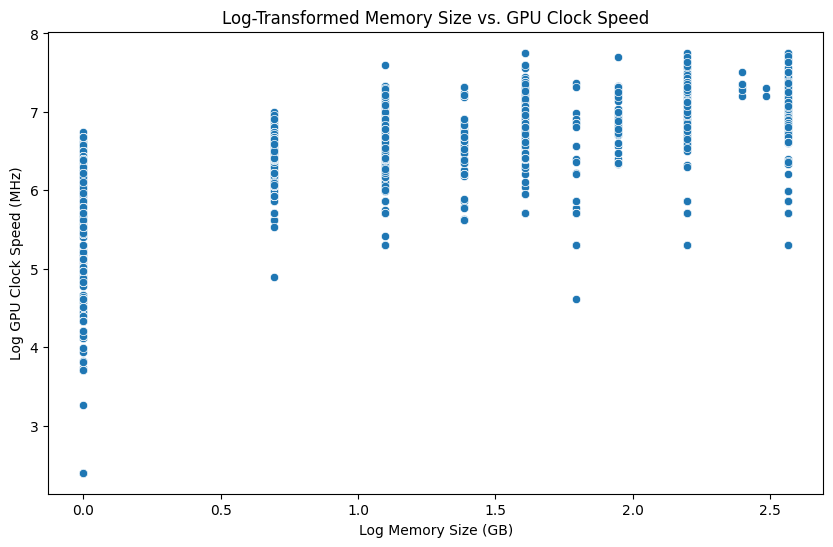

In [140]:
# Ensure there are no NaNs in the columns to be transformed
df['memSize'] = df['memSize'].fillna(df['memSize'].median())
df['gpuClock'] = df['gpuClock'].fillna(df['gpuClock'].median())

# Apply log transformation (log1p to handle zero values)
df['logMemSize'] = np.log1p(df['memSize'])
df['logGpuClock'] = np.log1p(df['gpuClock'])

# Create the scatter plot using the log-transformed data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='logMemSize', y='logGpuClock', data=df)
plt.title('Log-Transformed Memory Size vs. GPU Clock Speed')
plt.xlabel('Log Memory Size (GB)')
plt.ylabel('Log GPU Clock Speed (MHz)')
plt.show()